In [1]:
from cil.framework import BlockDataContainer, ImageGeometry
from cil.optimisation.operators import BlockOperator, IdentityOperator
import numpy as np
from cil.utilities import dataexample
from cil.utilities.display import show2D
from cil.plugins.ccpi_regularisation.functions.regularisers import  RegulariserFunction
from cil.plugins.ccpi_regularisation.functions import  FGP_TV
from cil.optimisation.functions import Function

# import engine module
import sirf.Gadgetron as pMR

# import further modules
import os
import numpy as np
import time
import matplotlib.pyplot as plt

### Reconstruct MR image data

In [2]:
# Trajectory for Golden angle radial acquisitions
def calc_rad_traj(ad):  
    dims = ad.dimensions()
    kx = np.linspace(-dims[2]//2, dims[2]//2, dims[2])
    ky = np.linspace(0, dims[0]-1, dims[0])
    
    # Check if angle is already specified:
    angRad = ky * (np.pi / 180) * (180 * 0.618034)

    # Normalise radial points between [-0.5 0.5]
    krad = kx
    krad = krad / (np.amax(np.abs(krad)) * 2)

    # Calculate trajectory
    rad_traj = np.zeros((dims[2], dims[0], 2), dtype=np.float32)
    rad_traj[:, :, 0] = krad.reshape(-1, 1) * np.cos(angRad)
    rad_traj[:, :, 1] = krad.reshape(-1, 1) * np.sin(angRad)
    rad_traj = np.moveaxis(rad_traj, 0, 1)    
    return(rad_traj)

In [3]:
pname = ''
fname = '2D_GRad_map_t1.h5'

In [4]:
# Load in the data
acq_data = pMR.AcquisitionData(pname + fname)
acq_data.sort_by_time()
acq_data = pMR.preprocess_acquisition_data(acq_data)

# Set trajectory
ktraj = calc_rad_traj(acq_data)
pMR.set_spiral2D_trajectory(acq_data, ktraj)

Started reading acquisitions from 2D_GRad_map_t1.h5
0%..10%..20%..30%..40%..50%..60%..70%..80%..90%..100%..
Finished reading acquisitions from 2D_GRad_map_t1.h5
Message received with ID: 5
Input stream has terminated


In [5]:
# Calculate coil sensitivity maps
csm = pMR.CoilSensitivityData()
csm.smoothness = 100
csm.calculate(acq_data)

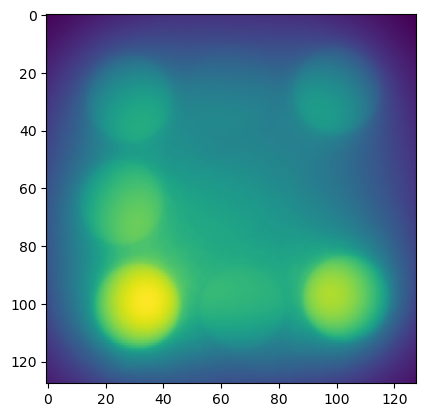

In [7]:
# Create acquisition model
E = pMR.AcquisitionModel(acqs=acq_data, imgs=csm)
E.set_coil_sensitivity_maps(csm)

# Inverse
i_mr = E.inverse(acq_data)
rec_im_inv_arr = i_mr.as_array()

plt.figure()
plt.imshow(np.abs(np.squeeze(rec_im_inv_arr)))

### TV Proximal For BlockDataContainers

- We start with a BlockDataContainer
- We make it a CIL ImageData
- Apply FGP_TV in real and imaginary
- Get a CIL DataContainer
- Make it a BlockDataContainer
- Continue with FISTA


### From BlockDataContainer to ImageData as an array

In [29]:
class BDCtoID():
    
    def __init__(self, bdc):
        
        self.bdc = bdc
        self.bdc_shape = bdc[0].shape
        
        # check that all datacontainers have the same shape
        all_shape = [i.shape for i in bdc.containers]
        num_containers = len(bdc.containers)
        if len(set(all_shape))>1:
            raise ValueError("Different shapes for containers")            
        if len(self.bdc_shape)==2:
            y, x = self.bdc_shape
            self.ig = ImageGeometry(voxel_num_y = y, voxel_num_x = x, channels=num_containers)
        elif len(self.bdc_shape)==3:            
            z,y,x = self.bdc_shape
            self.ig = ImageGeometry(voxel_num_z = z, voxel_num_y = y, voxel_num_x = x, 
                                    channels=num_containers)
        else:
            raise ValueError("not implemented")
            
        self.id_cil = self.ig.allocate(dtype=bdc[0].dtype)
        print(self.id_cil.dtype)

            
    def IDarray(self):
        
        #tmp = np.stack([i.array for i in self.bdc], axis=0) CIL
        tmp = np.stack([i.as_array() for i in self.bdc], axis=0)
        self.id_cil.fill(np.squeeze(tmp))
        return self.id_cil
    
    def BDC(self, image_data):
        if image_data.ndim<=2:
            raise ValueError("We cannot create a BlockDataContainer from a 2D array")
            
        num_slices = image_data.shape[0]
        splitted_arrays = np.squeeze(np.split(image_data.array, num_slices, axis=0))
        
        # reshape to make sure single dimensions are restored
        splitted_arrays = [np.reshape(arr, self.bdc_shape) for arr in splitted_arrays]
        
        # create new data container
        bdc = self.bdc.copy()
        for idx, container in enumerate(bdc.containers):
            container.fill(splitted_arrays[idx])
        return(bdc)


In [30]:
print("For three 2D ImageDataContainers ")    

# create bdc
bdc = BlockDataContainer(i_mr,i_mr,i_mr)


# blockdatacontainer to ImageData
bdctoid = BDCtoID(bdc)

new_id3D = bdctoid.IDarray()

print("Shape for every DataContainer in a BlockDataContainer {}".format([i.shape for i in bdc.containers]))
print("Shape of the new ImageData is {}".format(new_id3D.shape))

bdc_new = bdctoid.BDC(new_id3D)

print("Shape for every DataContainer in new BlockDataContainer {}".format([i.shape for i in bdc_new.containers]))

For three 2D ImageDataContainers 
complex64
Shape for every DataContainer in a BlockDataContainer [(1, 128, 128), (1, 128, 128), (1, 128, 128)]
Shape of the new ImageData is (3, 128, 128)
Shape for every DataContainer in new BlockDataContainer [(1, 128, 128), (1, 128, 128), (1, 128, 128)]


### Change proximal method of [RegulariserFunction](https://github.com/TomographicImaging/CIL/blob/master/Wrappers/Python/cil/plugins/ccpi_regularisation/functions/regularisers.py#L36)

In [59]:


def new_proximal(self, bd_x, tau, out=None):
    
    # self.check_input(x)
        
    bdctoid = BDCtoID(bd_x)        
    x = bdctoid.IDarray()

    arr = x.as_array()
    if np.iscomplexobj(arr):
        # do real and imag part indep
        in_arr = np.asarray(arr.real, dtype=np.float32, order='C')
        res, info = self.proximal_numpy(in_arr, tau)
        arr.real = res[:]
        in_arr = np.asarray(arr.imag, dtype=np.float32, order='C')
        res, info = self.proximal_numpy(in_arr, tau)
        arr.imag = res[:]
        self.info = info
        if out is not None:
            out.fill(bdctoid.BDC(arr))
        else:
            out = x.copy()
            out.fill(res)
            return bdctoid.BDC(out)
    else:
        arr = np.asarray(x.as_array(), dtype=np.float32, order='C')
        res, info = self.proximal_numpy(arr, tau)
        self.info = info
        if out is not None:
            out.fill(bdctoid.BDC(res))
        else:
            out = x.copy()
            out.fill(res)
            return bdctoid.BDC(out)

RegulariserFunction.proximal = new_proximal


In [60]:
# make copies of the CameraMan and make it a BlockDataContainer
num_chan = 3
block_data = BlockDataContainer(*[i_mr]*3)

### Run FGP_TV with a BlockDataContainer as input

In [61]:
alpha = 0.5
tv = alpha*FGP_TV()
res = tv.proximal(block_data, tau=1)
print("TV result dtype is {}".format(res.dtype))
print(res.shape)



    

complex64
TV result dtype is complex64
(3, 128, 128)


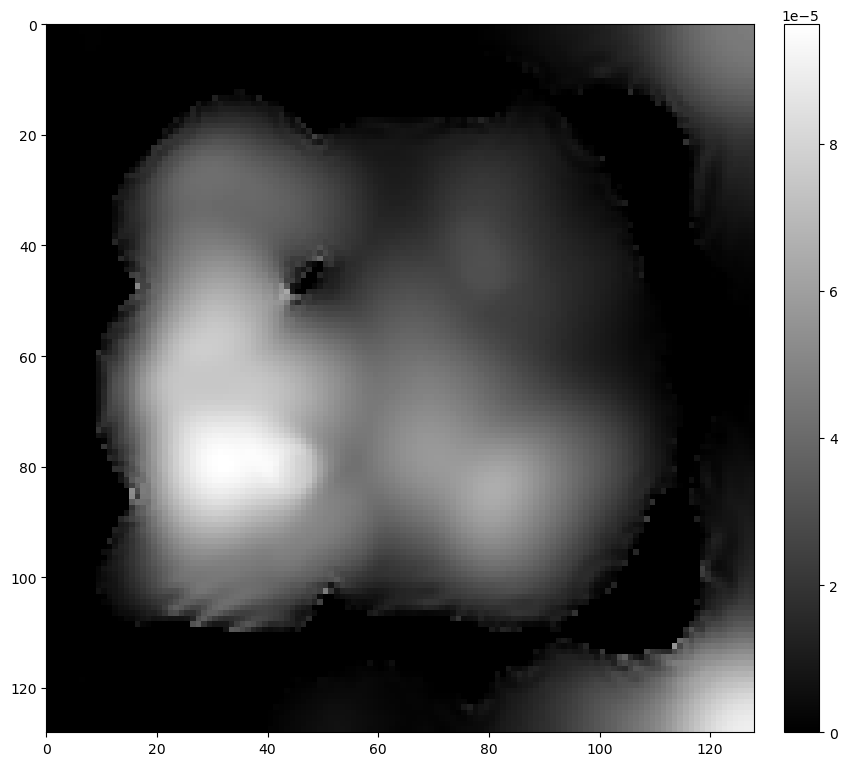

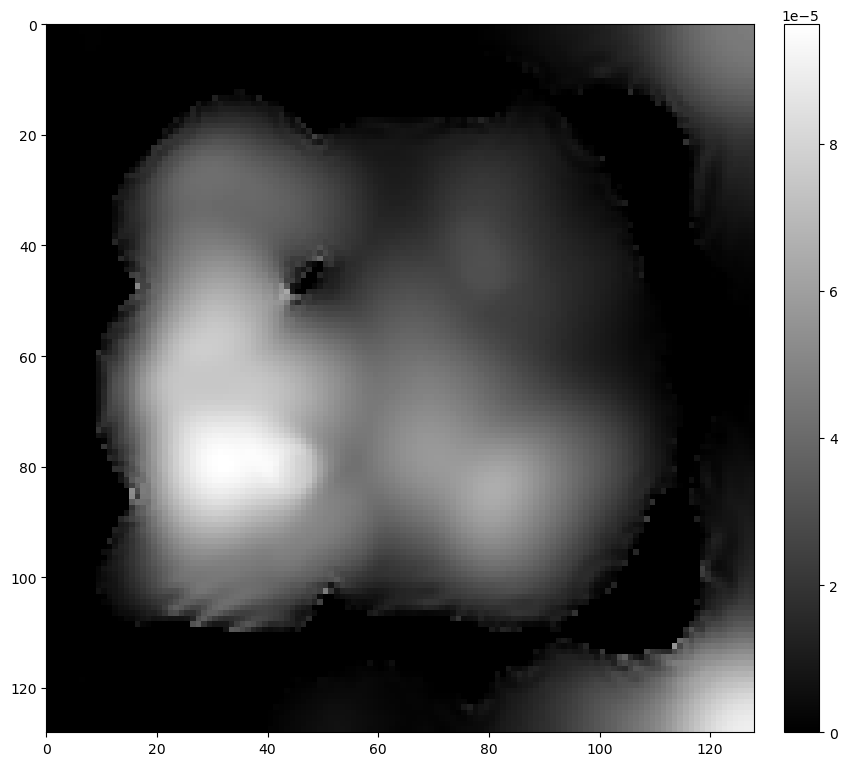

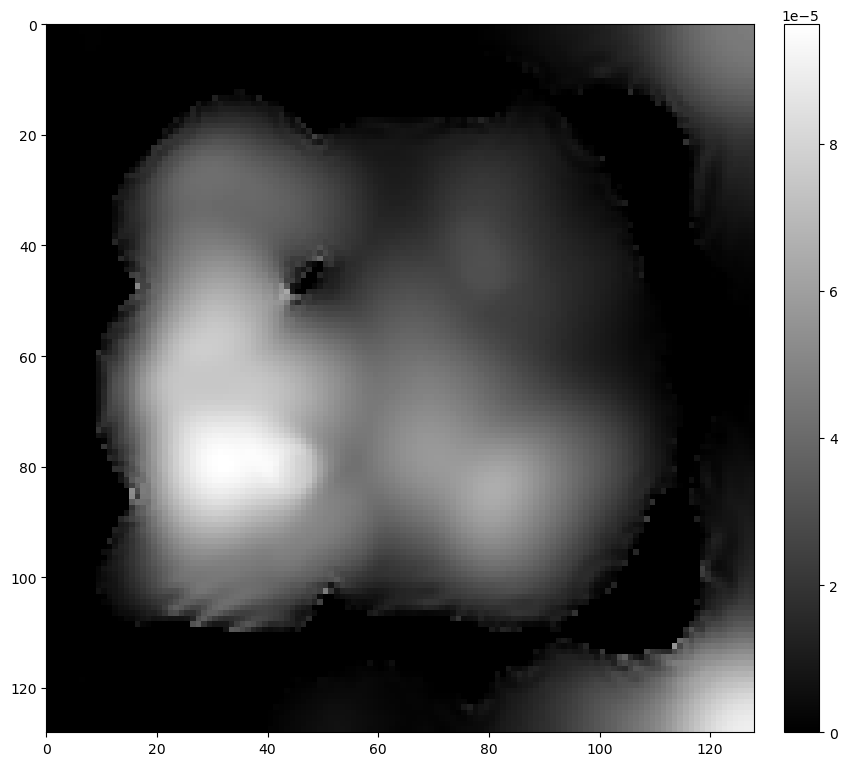

In [63]:
show2D(np.real(res.array[0]), origin="upper")
show2D(np.real(res.array[1]), origin="upper")
show2D(np.real(res.array[2]), origin="upper")

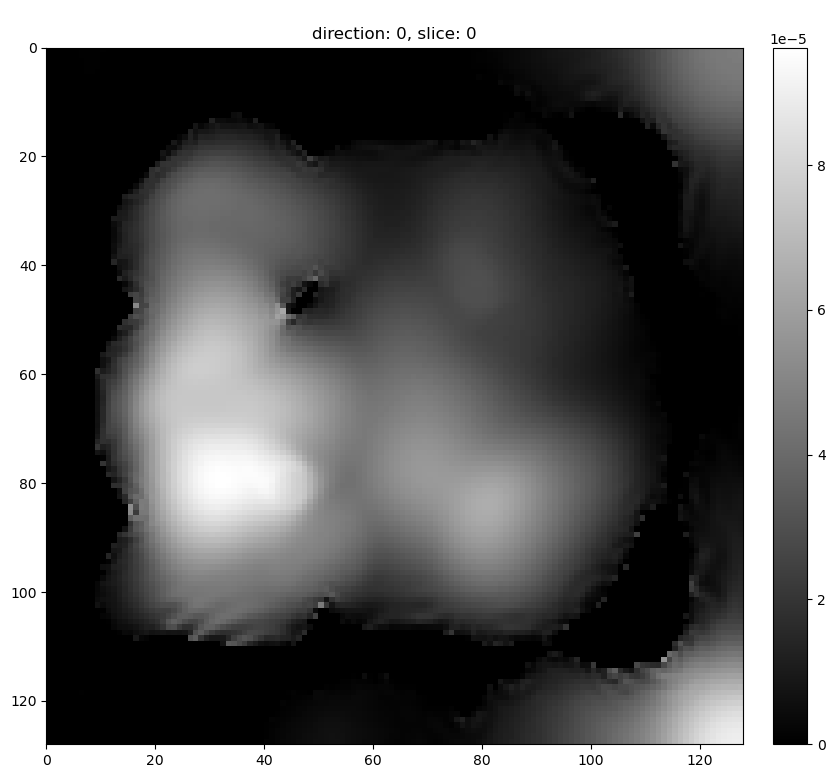

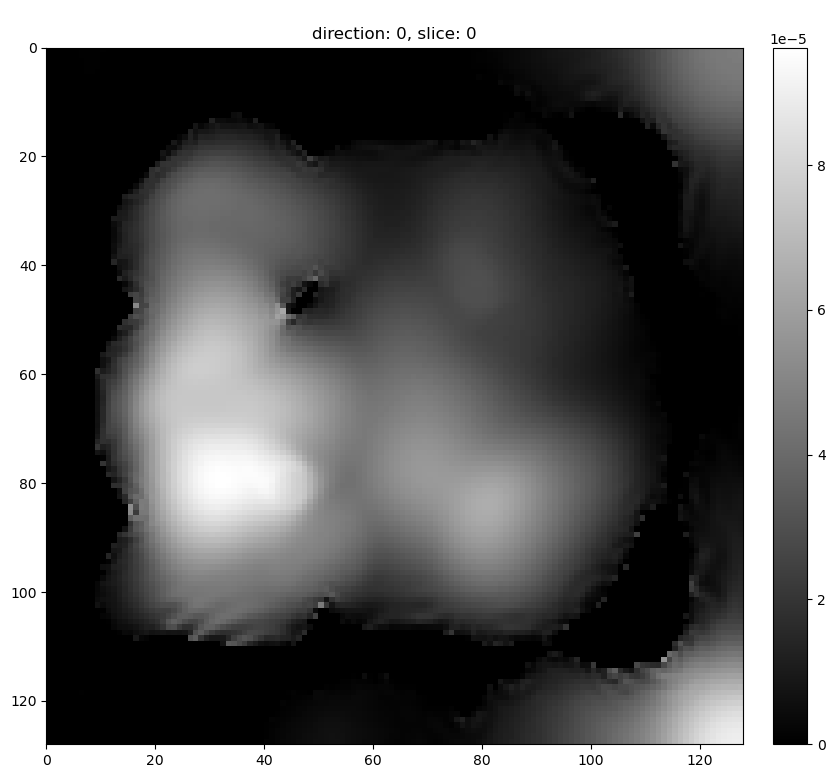

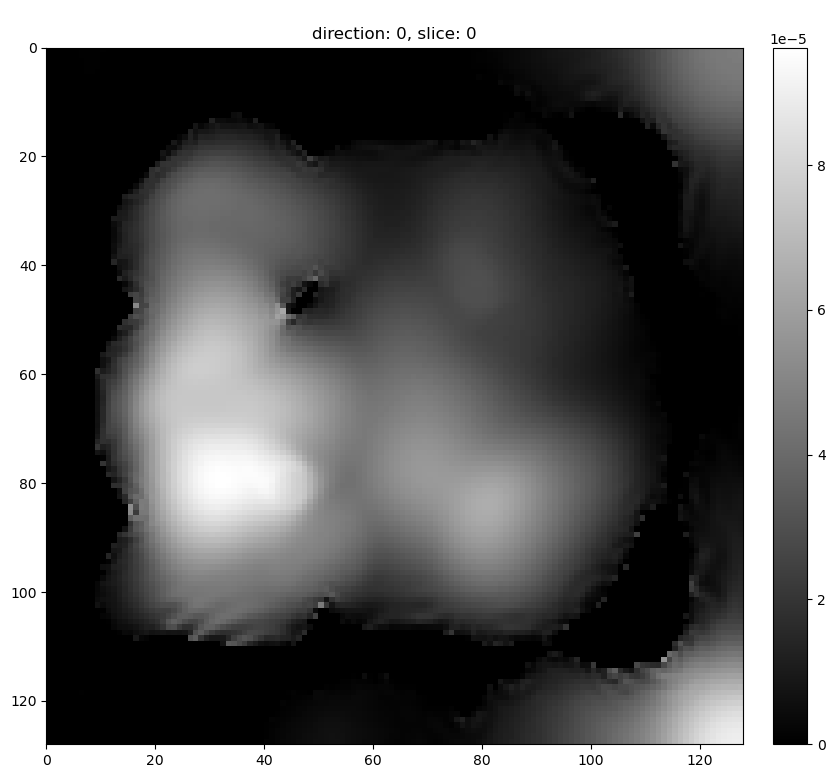

In [58]:
show2D(np.real(res[0].as_array()), origin="upper")
show2D(np.real(res[1].as_array()), origin="upper")
show2D(np.real(res[2].as_array()), origin="upper")